# Project 11: Numerical Methods
---

## Description:
- Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.
- Rusty Bargain is interested in:
    - the quality of the prediction
    - the speed of the prediction
    - the time required for training
---

## Instructions:
1. Download and look at the data.
2. Train different models with various hyperparameters (You should make at least two different models, but more is better. Remember, various implementations of gradient boosting don't count as different models.) The main point of this step is to compare gradient boosting methods with random forest, decision tree, and linear regression.
3. Analyze the speed and quality of the models.
---
**Notes:**
- Use the RMSE metric to evaluate the models.
- Linear regression is not very good for hyperparameter tuning, but it is perfect for doing a sanity check of other methods. If gradient boosting performs worse than linear regression, something definitely went wrong.
- On your own, work with the LightGBM library and use its tools to build gradient boosting models.
- Ideally, your project should include linear regression for a sanity check, a tree-based algorithm with hyperparameter tuning (preferably, random forrest), LightGBM with hyperparameter tuning (try a couple of sets), and CatBoost and XGBoost with hyperparameter tuning (optional).
- Take note of the encoding of categorical features for simple algorithms. LightGBM and CatBoost have their implementation, but XGBoost requires OHE.
- You can use a special command to find the cell code runtime in Jupyter Notebook. Find that command.
- Since the training of a gradient boosting model can take a long time, change only a few model parameters.
- If Jupyter Notebook stops working, delete the excessive variables by using the del operator:

## Data:
**Features**
- DateCrawled — date profile was downloaded from the database
- VehicleType — vehicle body type
- RegistrationYear — vehicle registration year
- Gearbox — gearbox type
- Power — power (hp)
- Model — vehicle model
- Mileage — mileage (measured in km due to dataset's regional specifics)
- RegistrationMonth — vehicle registration month
- FuelType — fuel type
- Brand — vehicle brand
- NotRepaired — vehicle repaired or not
- DateCreated — date of profile creation
- NumberOfPictures — number of vehicle pictures
- PostalCode — postal code of profile owner (user)
- LastSeen — date of the last activity of the user

**Target**
- Price — price (Euro)
---

In [1]:
# Library Imports:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Model Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Metric Imports
from sklearn.metrics import mean_squared_error

#### Note on Notebook Below:

The following notebook contains 5 trained models, some of which took over 25 minutes on my last run. The dataframe in the cell below shows the wall times in seconds to train each model after parameter tuning (which takes longer). To speed things up I would suggest not running the parameter tuning cells and focus on the final models.

## 1) Data Preprocessing
---

In [2]:
# UNCOMMENT IF USING JUPYTERHUB in PRACTICUM
path = '/datasets/car_data.csv'

# Path for my local Jupyter Notebook
# path = 'car_data.csv'

df = pd.read_csv(path)

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          354369 non-null object
price                354369 non-null int64
vehicletype          316879 non-null object
registrationyear     354369 non-null int64
gearbox              334536 non-null object
power                354369 non-null int64
model                334664 non-null object
mileage              354369 non-null int64
registrationmonth    354369 non-null int64
fueltype             321474 non-null object
brand                354369 non-null object
notrepaired          283215 non-null object
datecreated          354369 non-null object
numberofpictures     354369 non-null int64
postalcode           354369 non-null int64
lastseen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [6]:
# Count of Null Values by column

df.isna().sum().sort_values(ascending=False)

df = df.dropna()

- Since all columns with nulls are of the dtype: object, we cannot use a mean or median to replace them, so they get dropped

In [7]:
# Checking for duplicate rows
print('Before drop:', df.duplicated().sum())

# drop duplicate rows

df = df.drop_duplicates()
print('After drop:', df.duplicated().sum())


Before drop: 247
After drop: 0


In [8]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'mileage', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [9]:
df.describe()

,price,registrationyear,power,mileage,registrationmonth,numberofpictures,postalcode
count,245567.000000,245567.000000,245567.000000,245567.000000,245567.000000,245567.0,245567.000000
mean,5125.680959,2002.918287,119.971796,127297.112397,6.179401,0.0,51462.385259
std,4718.468928,6.164689,139.448062,37079.536493,3.479783,0.0,25839.798492
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1499.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30966.000000
50%,3500.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,50767.000000
75%,7500.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72379.000000
max,20000.000000,2018.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- Since the numberofpictures column only contains values of zero, it is constant and will have no effect on the model performance, therefore it can be dropped

In [10]:
drops = ['datecrawled', 'datecreated', 'lastseen', 'numberofpictures']

df = df.drop(drops, axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245567 entries, 3 to 354367
Data columns (total 12 columns):
price                245567 non-null int64
vehicletype          245567 non-null object
registrationyear     245567 non-null int64
gearbox              245567 non-null object
power                245567 non-null int64
model                245567 non-null object
mileage              245567 non-null int64
registrationmonth    245567 non-null int64
fueltype             245567 non-null object
brand                245567 non-null object
notrepaired          245567 non-null object
postalcode           245567 non-null int64
dtypes: int64(6), object(6)
memory usage: 24.4+ MB


Text(0, 0.5, 'Frequency')

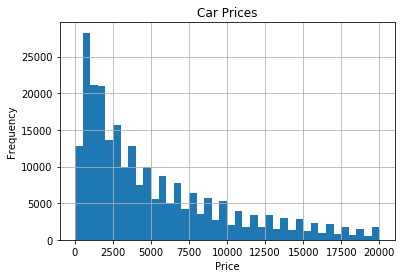

In [12]:
df['price'].hist(bins=40)
plt.title('Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

In [13]:
p0 = df['price'] == 0
print(p0.sum())
print(round(p0.sum() / len(p0), 4))

3386
0.0138


- Looking at the distribution of price, there is a clear majority of vehicles sold at lower prices
- About 3400 cars are listed for free, which is approximately 1.3% of all the cars we have in the data
- The consistent steps up and down show that many listings are at even numbers at multiples of (100, 500, 1000)

In [14]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,postalcode
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,19348


## Model Building:
- Track speed with the time library
- Metric for scoring is RMSE
---

#### Splitting the data:

In [15]:
# converting dtypes of features from Object to Categorical (should help speed up CatBoost model)

df.dtypes
df[['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']] = df[['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']].astype('category')
df.dtypes

price                   int64
vehicletype          category
registrationyear        int64
gearbox              category
power                   int64
model                category
mileage                 int64
registrationmonth       int64
fueltype             category
brand                category
notrepaired          category
postalcode              int64
dtype: object

In [16]:
features = df.drop('price', axis=1)
target = df['price']

x_train, xv, y_train, yv = train_test_split(features, target, test_size=0.4, random_state=123)
x_val, x_test, y_val, y_test = train_test_split(xv, yv, test_size=0.5, random_state=123)

# Copying each set to encode
enc_xt = x_train.copy()
enc_yt = y_train.copy()
enc_xv = x_val.copy()
enc_yv = y_val.copy()
enc_xtest = x_test.copy()
enc_ytest = y_test.copy()

# Encoding
to_encode = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

for i in to_encode:
    enc_xt[i + '_enc'] = LabelEncoder().fit_transform(enc_xt[i])
    enc_xt = enc_xt.drop(i, axis=1)
    enc_xv[i + '_enc'] = LabelEncoder().fit_transform(enc_xv[i])
    enc_xv = enc_xv.drop(i, axis=1)
    enc_xtest[i + '_enc'] = LabelEncoder().fit_transform(enc_xtest[i]) 
    enc_xtest = enc_xtest.drop(i, axis=1)

print('Shapes with Categorical Features')
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print('-----')
print('Label Encoded Shapes')
print(enc_xt.shape)
print(enc_xv.shape)
print(enc_xtest.shape)
print(enc_yt.shape)
print(enc_yv.shape)
print(enc_ytest.shape)
enc_xt.head()

Shapes with Categorical Features
(147340, 11)
(49113, 11)
(49114, 11)
(147340,)
(49113,)
(49114,)
-----
Label Encoded Shapes
(147340, 11)
(49113, 11)
(49114, 11)
(147340,)
(49113,)
(49114,)


,registrationyear,power,mileage,registrationmonth,postalcode,vehicletype_enc,gearbox_enc,model_enc,fueltype_enc,brand_enc,notrepaired_enc
315708,2010,143,150000,5,55288,7,1,29,2,1,0
128292,1997,150,150000,6,31177,4,1,15,6,2,1
18696,2000,0,150000,6,40822,5,1,83,6,24,0
170011,2007,131,150000,2,55129,0,1,223,2,37,0
96779,1999,75,150000,10,36369,7,1,59,2,20,0


In [17]:
# Setting up function to time cells and save to a variable

def my_time(start, end):
    diff_time = end - start
    return round(diff_time, 4)

### Linear Regression:
---

In [18]:
lr_start = time.time()

lr = LinearRegression()
lr.fit(enc_xt, enc_yt)

lr_end = time.time()
lr_time = my_time(lr_start, lr_end)
print('Time to Train:', lr_time)

Time to Train: 0.0376


In [19]:
lr_pred_val = lr.predict(enc_xv)
lr_mse = mean_squared_error(enc_yv, lr_pred_val)

lr_pred_test = lr.predict(enc_xtest)
lr_mse2 = mean_squared_error(enc_ytest, lr_pred_test)

print('Linear Regression:')
print('    Validation RMSE:', np.sqrt(lr_mse))
print('    Test RMSE:', np.sqrt(lr_mse2))

Linear Regression:
    Validation RMSE: 3363.7231132277816
    Test RMSE: 3331.4367769814703


### Random Forest:
---

In [20]:
# tuning max_depth

for i in range(19, 22, 1):
    rf_it = RandomForestRegressor(random_state=1234, max_depth=i)
    rf_it.fit(enc_xt, enc_yt)
    p = rf_it.predict(enc_xv)
    msq = mean_squared_error(enc_yv, p)
    print('depth:', i, 'Validation RMSE:', np.sqrt(msq))
    print('')

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


depth: 19 Validation RMSE: 1742.2168500660391



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


depth: 20 Validation RMSE: 1739.0625393291998



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


depth: 21 Validation RMSE: 1741.740710846312



In [21]:
rf_start = time.time()

rf = RandomForestRegressor(random_state=123, max_depth=20)
rf.fit(enc_xt, enc_yt)

rf_end = time.time()
rf_time = my_time(rf_start, rf_end)
rf_time

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5.9162

In [22]:
rf_p = rf.predict(enc_xtest)
rf_mse = mean_squared_error(enc_ytest, rf_p)
print('Random Forest Test RMSE:', np.sqrt(rf_mse))

Random Forest Test RMSE: 1762.5767311601335


### LightGBM:
---

In [23]:
# tuning max_depth

for i in range(18, 21):
    lg_it = lgb.LGBMRegressor(max_depth=i, random_state=1234)
    lg_it.fit(enc_xt, enc_yt)
    p = lg_it.predict(enc_xv)
    msq = mean_squared_error(enc_yv, p)
    print('depth:', i, 'Validation RMSE:', np.sqrt(msq))
    print('')
    

depth: 18 Validation RMSE: 1768.5061649331371

depth: 19 Validation RMSE: 1767.0290438438149

depth: 20 Validation RMSE: 1767.0290438438149



In [24]:
# tuning num_leaves

for i in range(57, 60):
    lg_it = lgb.LGBMRegressor(max_depth=19, num_leaves=i, random_state=1234)
    lg_it.fit(enc_xt, enc_yt)
    p = lg_it.predict(enc_xv)
    msq = mean_squared_error(enc_yv, p)
    print('leaves:', i, 'Validation RMSE:', np.sqrt(msq))
    print('')

leaves: 57 Validation RMSE: 1722.3458633264438

leaves: 58 Validation RMSE: 1719.7686084532527

leaves: 59 Validation RMSE: 1727.5885482556405



In [25]:
lg_start = time.time()

# Final Parameters
# Depth = 19
# num_leaves = 58

# FINAL LGBM:

lg = lgb.LGBMRegressor(max_depth=24, num_leaves=58, random_state=1234)
lg.fit(enc_xt, enc_yt)

lg_end = time.time()
lg_time = my_time(lg_start, lg_end)
lg_time

11.7821

In [26]:
lg_p = lg.predict(enc_xtest)
lg_mse = mean_squared_error(enc_ytest, lg_p)
print('LightGBM Test RMSE:', np.sqrt(lg_mse))

LightGBM Test RMSE: 1736.308449360193


### XGBoost:
---

In [27]:
# tuning max_depth (default=6)

for i in range(3, 6):
    xg_it = xgb.XGBRegressor(max_depth=i, verbosity=0, random_state=1234)
    xg_it.fit(enc_xt, enc_yt)
    p = xg_it.predict(enc_xv)
    msq = mean_squared_error(enc_yv, p)
    print('depth:', i, 'Validation RMSE:', np.sqrt(msq))
    print('')

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


depth: 3 Validation RMSE: 1966.0161235465569



/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


depth: 4 Validation RMSE: 1874.1809543731251



/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


depth: 5 Validation RMSE: 1811.324733559696



In [28]:
# tuning n_estimators

for i in range(175, 226, 25):
    xg_it = xgb.XGBRegressor(max_depth=5, n_estimators=i, verbosity=0, random_state=1234)
    xg_it.fit(enc_xt, enc_yt)
    p = xg_it.predict(enc_xv)
    msq = mean_squared_error(enc_yv, p)
    print('estimators:', i, 'Validation RMSE:', np.sqrt(msq))
    print('')

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


estimators: 175 Validation RMSE: 1766.11652734141



/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


estimators: 200 Validation RMSE: 1759.3173265175496



/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


estimators: 225 Validation RMSE: 1751.4791829167891



In [29]:
# tuning learning_rate

for i in [0.2, 0.3, 0.4]:
    xg_it = xgb.XGBRegressor(max_depth=6, n_estimators=200, learning_rate=i, verbosity=0, random_state=1234)
    xg_it.fit(enc_xt, enc_yt)
    p = xg_it.predict(enc_xv)
    msq = mean_squared_error(enc_yv, p)
    print('learning rate:', i, 'Validation RMSE:', np.sqrt(msq))
    print('')

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


learning rate: 0.2 Validation RMSE: 1692.9912150619978



/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


learning rate: 0.3 Validation RMSE: 1691.763353144611



/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


learning rate: 0.4 Validation RMSE: 1716.5566826406082



In [30]:
xg_start = time.time()

# Final XGBoost Parameters
# Max_depth = 5
# n_estimators = 200
# learning_rate = 0.3

xg = xgb.XGBRegressor(max_depth=5, n_estimators=200, learning_rate=0.3, verbosity=0, random_state=1234)
xg.fit(enc_xt, enc_yt)

xg_end = time.time()
xg_time = my_time(xg_start, xg_end)
xg_time

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


30.9988

In [31]:
xg_p = xg.predict(enc_xtest)
xg_mse = mean_squared_error(enc_ytest, xg_p)
print('XGBoost RMSE:', np.sqrt(xg_mse))

XGBoost RMSE: 1717.2355882837119


### CatBoost:
---

In [32]:
# tuning depth

for i in range(8, 11):
    cb_it = CatBoostRegressor(depth=i, cat_features=(0, 2, 4, 7, 8, 9), random_state=123, silent=True)
    cb_it.fit(x_train, y_train)
    p = cb_it.predict(x_val)
    msq = mean_squared_error(y_val, p)
    print('depth:', i, 'RMSE:', np.sqrt(msq))
    print('')

depth: 8 RMSE: 1643.3419741025436

depth: 9 RMSE: 1625.6597648710735

depth: 10 RMSE: 1609.383122700624



In [ ]:
# tuning iterations

for i in range(900, 1101, 100):
    cb_it = CatBoostRegressor(depth=10, iterations=i, cat_features=(0, 2, 4, 7, 8, 9), random_state=123, silent=True)
    cb_it.fit(x_train, y_train)
    p = cb_it.predict(x_val)
    msq = mean_squared_error(y_val, p)
    print('iterations:', i, 'RMSE:', np.sqrt(msq))
    print('')

iterations: 900 RMSE: 1615.7325768684195

iterations: 1000 RMSE: 1609.383122700624



In [34]:
# tuning learning_rate

for i in [0.2, 0.3, 0.4]:
    cb_it = CatBoostRegressor(depth=10, iterations=1100, learning_rate=i, cat_features=(0, 2, 4, 7, 8, 9), random_state=123, silent=True)
    cb_it.fit(x_train, y_train)
    p = cb_it.predict(x_val)
    msq = mean_squared_error(y_val, p)
    print('learning_rate:', i, 'RMSE:', np.sqrt(msq))
    print('')

In [35]:
cb_start = time.time()

# Final Params
# Depth = 15
# iterations = 1100
# learning_rate = 0.3

cb = CatBoostRegressor(depth=15, iterations=1100, learning_rate=0.3, cat_features=(0, 2, 4, 7, 8, 9), random_state=123, silent=True)
cb.fit(x_train, y_train)

cb_end = time.time()
cb_time = my_time(cb_start, cb_end)
cb_time

In [36]:
cb_p = cb.predict(x_test)
cb_mse = mean_squared_error(y_test, cb_p)
print('CatBoost RMSE:', np.sqrt(msq))

## 3) Speed and Quality of Models Compared

In [37]:
sq_dict = {
    'Model':['Linear Regression', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost'],
    'RMSE':[np.sqrt(lr_mse), np.sqrt(rf_mse), np.sqrt(lg_mse), np.sqrt(xg_mse), np.sqrt(cb_mse)],
    'Train Wall Time (sec)':[lr_time, rf_time, lg_time, xg_time, cb_time]
}

comps = pd.DataFrame(sq_dict)
comps

- The cell above shows the RMSE scores and the wall time to train each model type:
    - The CatBoost model scored best in terms of RMSE, but has the second longest Training time
    - LightGBM on the other hand had the shortest training time and the third best score
    - Overall, the gradient boosting models scored better than the sanity check (Linear Regression) and the Random Forest models.
    - Depending on the project one may prefer one of the Gradient Boost Models:
        - LightGBM for fastest training with a slight tradeoff for RMSE
        - CatBoost for best RMSE score, but a very long training time
        - XGBoost for a good balance with training much faster than CatBoost with an RMSE only 7% higher relative to CatBoost